In [37]:
# Import packages
'''
Import the required modules to run all code in this notebook.
'''
import os 
from IPython.display import HTML
from IPython.core.display import display
from ipywidgets import widgets, HBox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from sklearn import linear_model
from sklearn.metrics import r2_score

%matplotlib inline

C:\Users\gmendoza\AppData\Local\Temp\ipykernel_11400\3277845580.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [38]:
# Load dataset - any time when you want to reset your processing, run this cell.
'''
The loaded datasets are .csv-files. These are read and structured with the 
pandas (imported above as pd) package. In this code cell, you load all datasets
into pandas dataframes. If you leave the lines below unchanged, these are:

    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data 
'''
s_site = 'M'

# Parameters
cl = 0.2      # 0.2, 0.3, 0.4
percent = 10   # 10, 20, 30
# Inversion parameters
#sample_loc = 'mean' # 'mean' or 'closest'
#FM = 'FSeq' #'CS', 'FSlin' or 'FSeq'
#MinM = 'Gauss-Newton'  
#alpha = 0.01
#remove_coil = True
#start_avg = True
#constrain = True

################################################### Calibrated rECa data ##########################################
# Define input datatype and source folder
datafolder = 'data' # data folder
datafolder_ERT = 'data/ERT'
data_sanalysis_folder = 'data/soil_analyses'

cal_folder = os.path.join(datafolder, 'calibrated')

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    #config['instrument_code'] == 'Dualem-21HS'
    emfile_prefix = 'proefhoeve_21HS'
    #else: 
    #    emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'

em_survey = os.path.join(cal_folder, f'{emfile_prefix}_raw_calibrated_rECa_{cl}_{percent}.csv')
em_survey = pd.read_csv(em_survey, sep=',', header=0)
df = em_survey

em_rec = os.path.join(cal_folder, f'{emfile_prefix}_raw_transect_calibrated_rECa_{cl}_{percent}.csv')
em_rec = pd.read_csv(em_rec, sep=',', header=0)
dt = em_rec

sampleprop = os.path.join(data_sanalysis_folder, f'{profile_prefix}_soil_analysis.csv')
samples_analysis = pd.read_csv(sampleprop, sep=',', header=0)
d = samples_analysis
d_cal = d.iloc[:10]
d_val = d[10:]

d_cal

,code,x,y,z,t,depth,humus,pH_eau,CEC,clay,silt,sand,caCO,TOC,bd,vwc,copeky,temp,rperm,iperm
0,1,41565.381,204207.342,0,0,10,2.516,7.84,20.725,22.106,65.499,12.396,0.000,12.58,1.281,0.26224,13,32.7,10.7,10.3
1,2,41549.211,204310.992,0,0,10,1.162,8.32,20.482,25.616,59.907,14.477,2.100,8.27,1.403,0.41344,20,31.1,28.1,35.1
2,3,41588.221,204167.503,0,0,10,2.714,8.32,23.113,24.670,66.901,8.430,4.000,18.31,1.386,0.30754,22,28.3,8.7,6.4
3,4,41668.451,204238.440,0,0,10,1.622,8.17,24.345,27.206,66.315,6.478,1.700,10.14,1.279,0.32295,24,31.6,16.7,18.5
4,5,41520.385,204334.195,0,0,10,1.686,8.18,20.992,26.516,58.833,14.650,2.400,11.35,1.413,0.41837,7,26.2,17.6,20.7
5,6,41615.875,204258.051,0,0,10,2.890,8.29,22.163,23.213,64.251,12.535,1.500,16.25,1.436,0.35694,5,28.3,11.3,6.4
6,7,41578.212,204271.787,0,0,10,1.758,8.19,21.157,25.013,59.196,15.791,1.100,10.11,1.306,0.27939,4,31.1,13.3,13.1
7,8,41533.320,204357.264,0,0,10,2.594,8.21,22.041,25.989,58.685,15.325,2.000,15.40,1.435,0.44652,15,25.4,17.1,18.5
8,9,41642.385,204297.786,0,0,10,3.398,8.34,22.787,21.302,65.610,13.088,2.200,16.99,1.366,0.36434,16,28.6,20.2,20.3
9,10,41702.154,204262.206,0,0,10,1.758,8.17,23.295,31.426,60.784,7.790,1.383,10.45,1.366,0.32171,8,27.2,12.1,13.7


Data visualization
------------------
Here you can plot the data based on its geographical coordinates. For this, you use the module 'pyplot' from the package 'matplotlib' (imported as 'plt').
In the code block below, you have examples of how to plot point datasets as a scatterplot ("plt.scatter")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


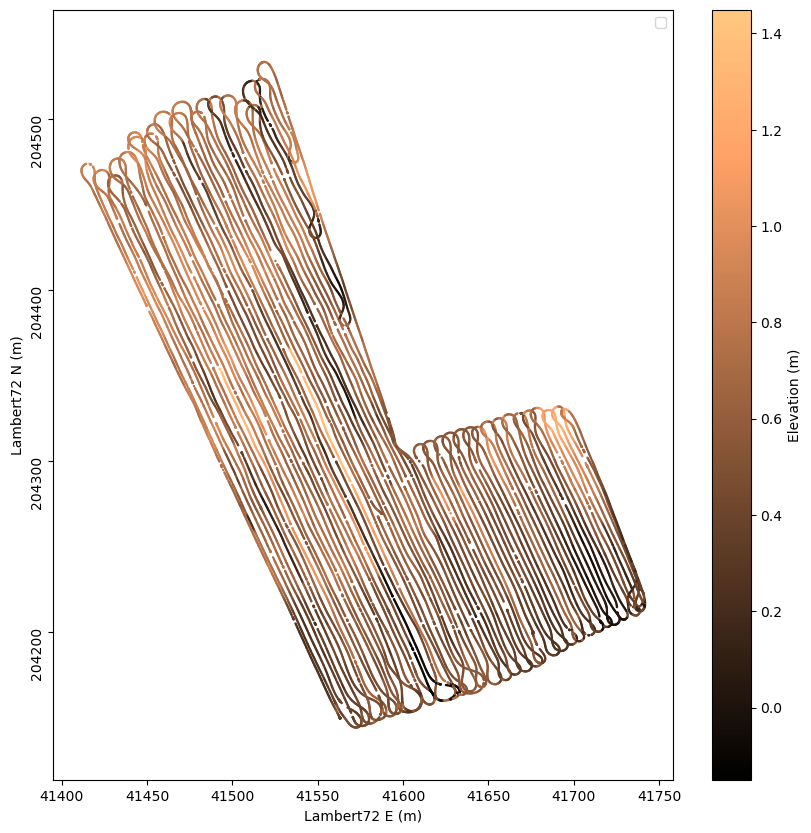

In [39]:
# Visualize GPS coordinates (x,y,z) as a scatterplot. 
'''
General plotting example, plotting the values of the dataframe columns
containing the x & y coordinates, and the elevation as a scatterplot. 
For this, you use the Python package Matplotlib (a submodule imported as 'plt').

In this example, you plot the FDEM survey data in the dataframe 'df', and
overlay it with the reference transect in dataframe 'dt'. 
You make explicit that you want to work with the values of the dataframe 
by calling the '.values' method of the dataframe. You can call specific 
columns by specifying their header as df['headername'].
 
'''
plt.figure(figsize=(10, 10))
# plotting the 'df' dataframe as a scatterplot
plt.scatter(df['x'].values,     # x values of the dataframe
            df['y'].values,     # y values of the dataframe
            c=df['z'].values,   # z values, used the colorgrade the scatterplot
                                # markers
            s=.5,               # size of the scatterplot markers
            cmap = 'copper')    # colormap for the scatterplot

# plotting the 'dt' dataframe as a line
#plt.plot(dt['x'].values,
#        dt['y'].values,
#        color = 'blue',
#        label = 'FDEM transect')
plt.colorbar().set_label('Elevation (m)')

plt.axis('equal')
plt.xlabel('Lambert72 E (m)')
plt.ylabel('Lambert72 N (m)')
plt.yticks(rotation = 90)
plt.legend()
plt.show()

#plt.savefig('data_visualization.png') 

## Plotting measurement data
In the cell below, you are again plotting the FDEM survey data, only this time, you will plot the output of the data recorded with the various coil configurations. 
By changing the coil geometry type (HCP0.5 - 2.0 or PRP0.6 - 2.1), and the signal component (inphase = False/True), you can visualise the survey measurement data. This will  show you the spatial variation in the data as a first basis for interpretation.<br><br>
You can specify if you want to plot the inphase data or the ECa data by setting the boolean inphase variable to True or False, respectively. 
In the second cell below this text, you can plot the histograms for the IP and QP responses for a given coil geometry.

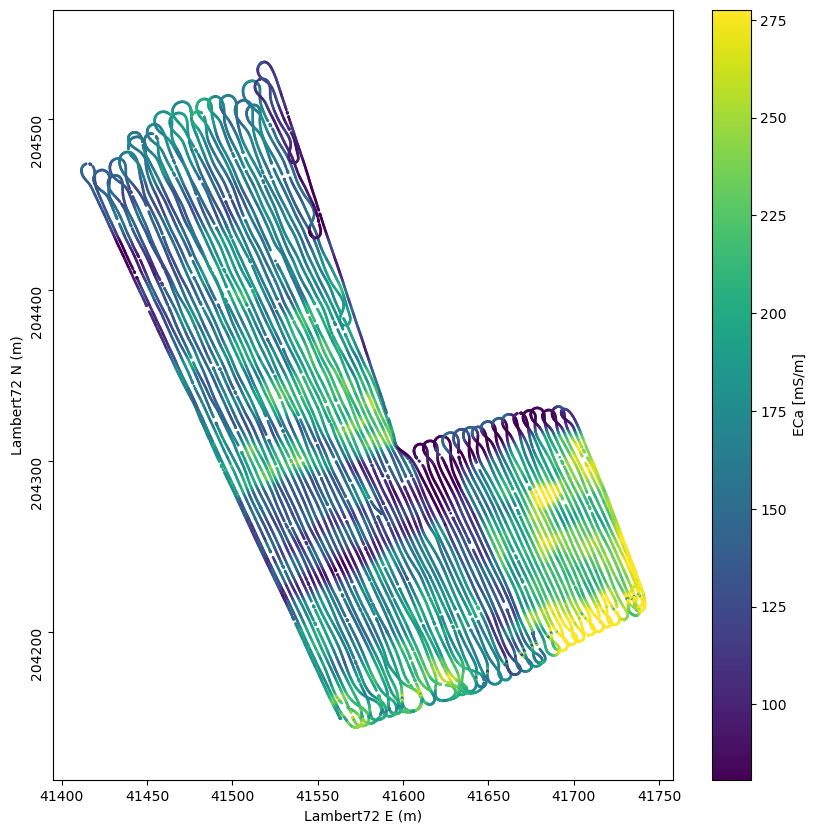

In [40]:
# Coil configuration
cgeometry = 'HCP1QP' # specify coil geometry ('HCP0.5', 'HCP1.0', 'HCP2.0', 
                     # 'PRP0.6', 'PRP1.1', 'PRP2.1')
inphase = False # boolean, False = ECa data; True = inphase data (in ppt)

if inphase:
    cc = cgeometry + '_inph'
    label = 'IP [ppt]'
    colorscale = 'Greys'
else:
    cc = cgeometry
    label = 'ECa [mS/m]'
    #colorscale = 'viridis_r'

# Colorbar range
cmin_percentile = 2  # %
cmax_percentile = 98  # %
lim0 = np.percentile(df[cc].values, cmin_percentile)
lim1 = np.percentile(df[cc].values, cmax_percentile)

# Visualize the survey itself
plt.figure(figsize=(10, 10))

plt.scatter(df['x'].values, 
            df['y'].values, 
            c=df[cc].values,
            s=1.)

plt.colorbar().set_label(label)
plt.clim(lim0, lim1)
plt.gca().set_ylabel(label)
plt.axis('equal')
plt.xlabel('Lambert72 E (m)')
plt.ylabel('Lambert72 N (m)')
plt.yticks(rotation = 90)
plt.show()

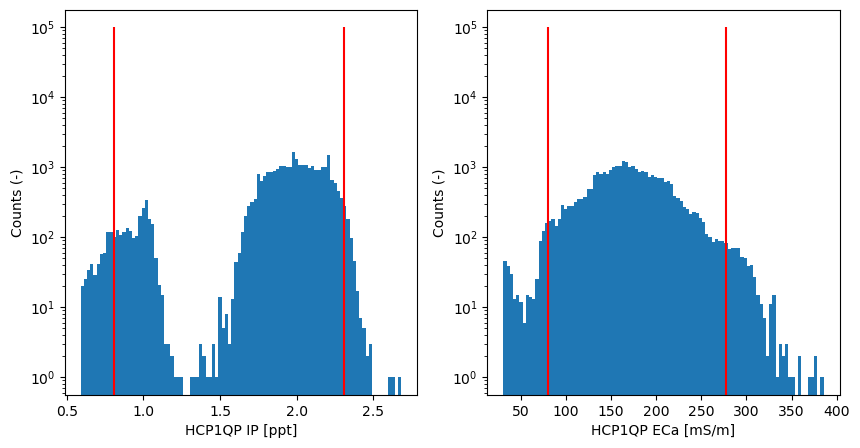

In [41]:
# Run this cell to visualize the histogram of the IP and ECa data 
# from the coil geometry specified in the cell above.

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cci = 'HCP1IP'
plt.hist(df[cci].values, bins=100, log=True)
plt.vlines([np.percentile(df[cci].values, cmin_percentile), 
            np.percentile(df[cci].values, cmax_percentile)], 
           0, 1e5, 
           colors='red')
plt.xlabel(cgeometry + ' IP [ppt]')
plt.ylabel('Counts (-)')

plt.subplot(1, 2, 2)
ccq = cgeometry
plt.hist(df[ccq].values, bins=100, log=True)
plt.vlines([np.percentile(df[ccq].values, cmin_percentile), 
            np.percentile(df[ccq].values, cmax_percentile)], 
           0, 1e5, 
           colors='red')
plt.xlabel(cgeometry +' ECa [mS/m]')
plt.ylabel('Counts (-)')
plt.show()

# 1. Spatial interpolation
---

If we want to move the data space from scattered point observations towards evenly spread observations or raster data we need to make use of a spatial interpolation algorithm.
Examples of these algorithms include nearest neighbor interpolation, linear and cubic interpolation.

You can perform such a simple interpolation in the cells below. For this, you have to define an evenly spaced grid to which the algorithm has to interpolate to.
The interpolation takes the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) as standard boundaries for the interpolation, so there unwanted extrapolation is possible.

In [42]:
'''
Here you perform a simple linear interpolation (alternatively, nearest 
neighbor or cubic interpolation can be performed as well by selecting the 
desired method in the 'griddata' function). 
For interpolating, you simply have to specify the dataset you want to 
interpolate (dataset), and the cell size of the final raster (
i.e., the resolution of the output grid).
'''

# Input variables
dataset = 'HCP1QP' # column of data values to interpolate
cell_size = 0.5  # raster cell size in meters

# Define an evenly spaced grid over which the dataset values have to be 
# interpolated
x_min = df['x'].min()
x_max = df['x'].max()
y_min = df['y'].min()
y_max = df['y'].max()
x_vector = np.arange(x_min, x_max, cell_size)
y_vector = np.arange(y_min, y_max, cell_size)

# Interpolate 
xx, yy = np.meshgrid(x_vector, y_vector)
data_grid = griddata(np.vstack((df['x'].values, df['y'].values)).T, 
                df[dataset].values, 
                (xx, yy), 
                method='linear')  # other methods (nearest, cubic)

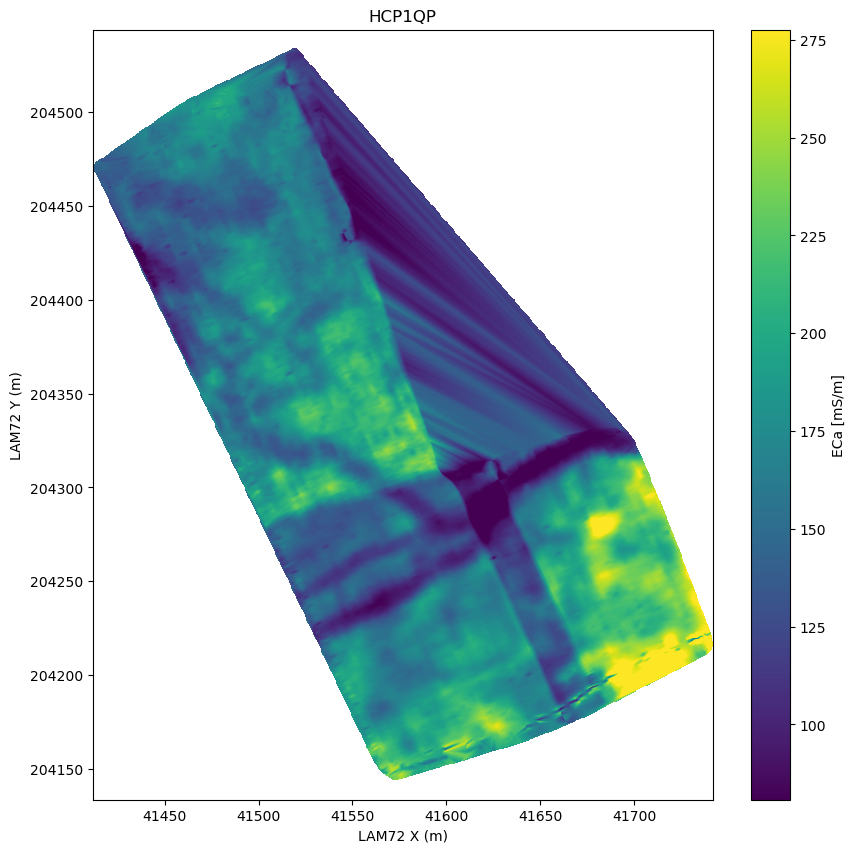

In [43]:
'''
With this code, you can plot your interpolated dataset.
'''

# Check if inphase or ECa data and set parameters accordingly
if 'IP' not in dataset:
        #colorscale = 'viridis_r'
        label = 'ECa [mS/m]'
else:        
        colorscale = 'Greys'
        label = 'IP [ppt]'

# Plot interpolated data
plt.figure(figsize=(10, 10))
plt.imshow(
        data_grid, 
        origin='lower', 
        extent=[x_min, x_max, y_min, y_max]
        )

# set plot range based on dataset value percentiles
plt.clim(
        np.percentile(df[dataset].values, 2), 
        np.percentile(df[dataset].values, 98)
        )
plt.colorbar().set_label(label)
plt.axis('equal')
plt.title(dataset)
plt.xlabel('LAM72 X (m)')
plt.ylabel('LAM72 Y (m)')
plt.show()

## Available sample data

In preparation for this exercise, latin hypercube sampling was already performed using an available FDEM dataset. 
Samples were taken by considering the x, y coordinates, and the ECa data from the PRP 1.1 and HCP 2.0 m coil configurations. <br>
Two sampling datasets were collected. A calibration dataset (`d_cal`), consisting of 10 samples, and a validation dataset (`d_val`), consisting of 5 samples. In both cases, the cLHS algorithm was run separately to generate the sample datasets.
At each sampling location, soil samples were taken at two depth intervals below the surface: at 10-15 cm, and at 50-55 cm depth.

In [44]:
d_cal

,code,x,y,z,t,depth,humus,pH_eau,CEC,clay,silt,sand,caCO,TOC,bd,vwc,copeky,temp,rperm,iperm
0,1,41565.381,204207.342,0,0,10,2.516,7.84,20.725,22.106,65.499,12.396,0.000,12.58,1.281,0.26224,13,32.7,10.7,10.3
1,2,41549.211,204310.992,0,0,10,1.162,8.32,20.482,25.616,59.907,14.477,2.100,8.27,1.403,0.41344,20,31.1,28.1,35.1
2,3,41588.221,204167.503,0,0,10,2.714,8.32,23.113,24.670,66.901,8.430,4.000,18.31,1.386,0.30754,22,28.3,8.7,6.4
3,4,41668.451,204238.440,0,0,10,1.622,8.17,24.345,27.206,66.315,6.478,1.700,10.14,1.279,0.32295,24,31.6,16.7,18.5
4,5,41520.385,204334.195,0,0,10,1.686,8.18,20.992,26.516,58.833,14.650,2.400,11.35,1.413,0.41837,7,26.2,17.6,20.7
5,6,41615.875,204258.051,0,0,10,2.890,8.29,22.163,23.213,64.251,12.535,1.500,16.25,1.436,0.35694,5,28.3,11.3,6.4
6,7,41578.212,204271.787,0,0,10,1.758,8.19,21.157,25.013,59.196,15.791,1.100,10.11,1.306,0.27939,4,31.1,13.3,13.1
7,8,41533.320,204357.264,0,0,10,2.594,8.21,22.041,25.989,58.685,15.325,2.000,15.40,1.435,0.44652,15,25.4,17.1,18.5
8,9,41642.385,204297.786,0,0,10,3.398,8.34,22.787,21.302,65.610,13.088,2.200,16.99,1.366,0.36434,16,28.6,20.2,20.3
9,10,41702.154,204262.206,0,0,10,1.758,8.17,23.295,31.426,60.784,7.790,1.383,10.45,1.366,0.32171,8,27.2,12.1,13.7


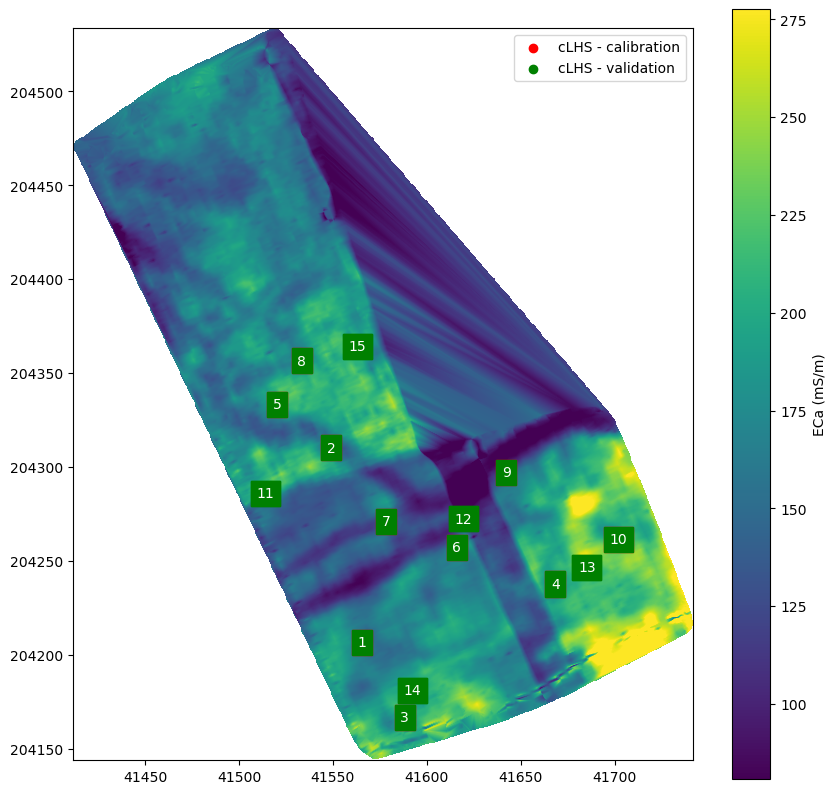

In [45]:
'''
Here you can visualise the sampling locations of the available cLHS dataset
plotted over the dataset you have interpolated above.
'''

# visualing the interpolated dataset
plt.figure(figsize=(10, 10))
plt.imshow(data_grid, origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.colorbar().set_label('ECa (mS/m)')
plt.clim(np.percentile(df[dataset].values, 2), np.percentile(df[dataset].values, 98))

# plotting the 'd_cal' dataframe as points (with their sampling ID)
marker_color = 'red'
font_color = 'white'
plt.scatter(d_cal['x'].values,
        d_cal['y'].values,
        color = marker_color,
        label = 'cLHS - calibration')
for (xi, yi, zi) in zip(d_cal['x'].values, d_cal['y'].values, d_cal['code'].values):
    plt.text(xi, yi, zi, va='center_baseline', 
             ha='center', 
             color = font_color, 
             backgroundcolor = marker_color)

# plotting the 'd_val' dataframe as points (with their sampling ID)
marker_color = 'green'
font_color = 'white'
plt.scatter(d_val['x'].values,
        d_val['y'].values,
        color = marker_color,
        label = 'cLHS - validation')
for (xi, yi, zi) in zip(d_val['x'].values, d_val['y'].values, d_val['code'].values):
    plt.text(xi, yi, zi, 
             va='center_baseline', 
             ha='center', 
             color = font_color,  
             backgroundcolor = marker_color)
plt.legend()


## Data extraction

If you want to extract the data values at the sampling locations, there are two ways to do this. 
First, you can simply query the dataframe that you want to extract the values from (e.g., `df`), to extract the data at the sampled locations (i.e., the x,y-coordinates in `d_cal` or `d_val`). Since samples are taken at coordinates that occur in the survey dataset (`df`), the exact same coordinates are present in the sampling (`d_cal` and `d_val`) and survey (`df`) dataframes.
You can extract the coordinates by performing an inner merge operation as in the first cell below.

Alternatively, you can perform a k-nearest neighbor search using [scipy]('https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html'). This is useful if you are unsure if the coordinates are exactly the same in both datasets. The second code cell perfoms this operation for reference.

These operations are useful to compare different datasets or datatypes, and if you want to perform regressions and predictions based on these data. <br> Below the first two code cells, an example is given on how to perform a [linear regression with Scikit learn](https://scikit-learn.org/stable/modules/linear_model.html), and [polynomial regression using Numpy](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html).

In [46]:
'''
Scipy method - knn search
-------------------------
Perform a knn-search on two dataframes to identify points that are closest
between columns of an input dataframe (in the case below 'df'), and a query
dataframe (in the case below the calibration sample dataset 'd_cal').
'''

# transform dataframes to numpy arrays and perform knn search
data_in = np.array(list(zip(df['x'].values,df['y'].values)) )
data_query = np.array(list(zip(d_cal['x'].values,d_cal['y'].values)) )
btree = cKDTree(data_in)
dist, idx = btree.query(data_query, k=1) # k = number of neighbors; 
                                         # idx = index of the neighbors
                                         # dist = distance between the neighbors       

# Concatenate the survey data values at the location closest to the 
# queried dataset based on the indices 'idx' (df.iloc[idx]), and the queried 
# data themselves.
calibration_set = pd.concat(
    [
    df.iloc[idx],   # part of original dataframe that is closest to queried data                    
    d_cal.set_index(df.iloc[idx].index) # reset index of the queried dataframe
    .rename(columns = {'x':'x_clhs','y':'y_clhs'}) # and rename the x-y columns
    ],
    axis=1 #concatenate along the correct axis (i.e., along the columns)
    )

print('calibration_set', calibration_set)
calibration_set.to_csv('calibration_merge.csv')

calibration_set                  x            y         z         t      HCP1QP      PRP1QP  \
5707   41564.53508  204206.6350  0.550000  46700.42  155.323595   75.250364   
11480  41548.70351  204311.6093  0.849275  48080.26  140.264887  114.866074   
6927   41589.68646  204167.8156  0.550000  46944.42  194.061395   96.639897   
25046  41668.92012  204238.2888  0.450000  53527.92  184.980220   95.772355   
8518   41521.64592  204334.5815  0.850000  47262.62  210.603442  169.633343   
19201  41617.05436  204259.0171  0.614979  51612.30  174.615236   88.255064   
13168  41576.95294  204271.2311  1.150000  48437.26  123.653554   51.572522   
12607  41533.54743  204357.0333  0.650000  48325.06  164.294294  134.555400   
25333  41642.94946  204299.0550  0.650000  53586.61  131.758487   75.828189   
28024  41701.02230  204261.7069  0.050000  54124.14  220.731932  120.076277   

           HCP2QP      PRP2QP      HCP4QP      PRP4QP  ...    silt    sand  \
5707   232.333267  117.245192  373.4

In [47]:
'''
Scipy method - knn search
-------------------------
Perform a knn-search on two dataframes to identify points that are closest
between columns of an input dataframe (in the case below 'df'), and a query
dataframe (in the case below the validation sample dataset 'd_val').
'''

# transform dataframes to numpy arrays and perform knn search
data_in = np.array(list(zip(df['x'].values,df['y'].values)) )
data_query = np.array(list(zip(d_val['x'].values,d_val['y'].values)) )
btree = cKDTree(data_in)
dist, idx = btree.query(data_query, k=1) # k = number of neighbors; 
                                         # idx = index of the neighbors
                                         # dist = distance between the neighbors       

# Concatenate the survey data values at the location closest to the 
# queried dataset based on the indices 'idx' (df.iloc[idx]), and the queried 
# data themselves.
validation_set = pd.concat(
    [
    df.iloc[idx],   # part of original dataframe that is closest to queried data                    
    d_val.set_index(df.iloc[idx].index) # reset index of the queried dataframe
    .rename(columns = {'x':'x_clhs','y':'y_clhs'}) # and rename the x-y columns
    ],
    axis=1 #concatenate along the correct axis (i.e., along the columns)
    )

validation_set.to_csv('validation_merge.csv')

In [48]:
## ****************************************************************************************

x0 = dt.x[0] 
x1 = dt.x[1]
y0 = dt.y[0] 
y1 = dt.y[1]

dtx = x0 + (-x0 + x1)*np.linspace(0, 1, num=1000)
dty = y0 + (-y0 + y1)*np.linspace(0, 1, num=1000)  

dt_int = pd.DataFrame()
dt_int['x'] = dtx
dt_int['y'] = dty

dt_int = dt_int.round({'x': 3, 'y': 3})

# transform dataframes to numpy arrays and perform knn search
data_in = np.array(list(zip(df['x'].values, df['y'].values)) )
data_query = np.array(list(zip(dt_int['x'].values, dt_int['y'].values)) )
btree = cKDTree(data_in)
dist, idx = btree.query(data_query, k=1) # k = number of neighbors; 
                                         # idx = index of the neighbors
                                         # dist = distance between the neighbors       

# Concatenate the survey data values at the location closest to the 
# queried dataset based on the indices 'idx' (df.iloc[idx]), and the queried 
# data themselves.
ERT_PH_set = pd.concat(
    [
    df.iloc[idx],   # part of original dataframe that is closest to queried data                    
    dt_int.set_index(df.iloc[idx].index) # reset index of the queried dataframe # and rename the x-y columns
    ],
    axis=1 #concatenate along the correct axis (i.e., along the columns)
    )
ERT_PH_set['pos'] = ((-x0 + x1)**2 + (-y0 + y1)**2)**0.5*np.linspace(0, 1, num=1000)

print('ERT_PH_set', ERT_PH_set)
ERT_PH_set.to_csv('ERT_PH_set.csv')

ERT_PH_set                  x            y         z         t      HCP1QP     PRP1QP  \
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
...            ...          ...       ...       ...         ...        ...   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   
27260  41668.31481  204315.4004  0.720451  53970.75  107.904078  70.050616   

           HCP2QP      PRP2QP      HCP4QP      PRP4Q

<Figure size 1000x1000 with 0 Axes>

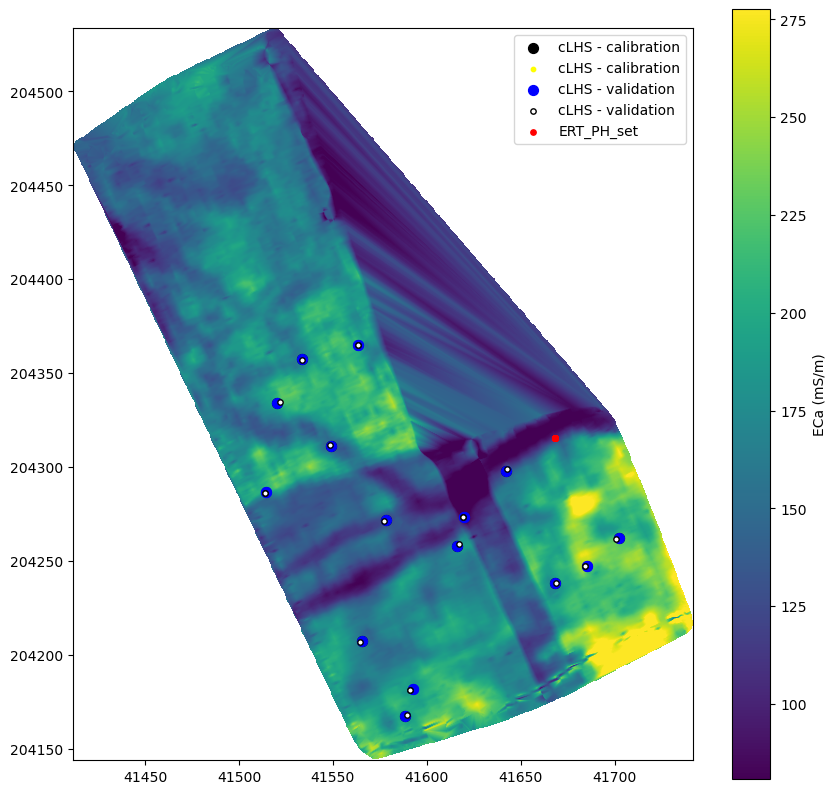

In [49]:
plt.figure(figsize=(10, 10))

# visualing the interpolated dataset
plt.figure(figsize=(10, 10))
plt.imshow(data_grid, origin='lower', extent=[x_min, x_max, y_min, y_max])
plt.colorbar().set_label('ECa (mS/m)')
plt.clim(np.percentile(df[dataset].values, 2), np.percentile(df[dataset].values, 98))

plt.scatter(d_cal['x'].values,
        d_cal['y'].values,
        color = 'black', # marker color
        s = 50, # marker size
        label = 'cLHS - calibration')
plt.scatter(calibration_set['x'].values,
        calibration_set['y'].values,
        color = 'yellow',
        s = 10,
        label = 'cLHS - calibration')

plt.scatter(d_val['x'].values,
        d_val['y'].values,
        color = 'blue',
        s = 50,
        label = 'cLHS - validation')
plt.scatter(validation_set['x'].values,
        validation_set['y'].values,
        color = 'white',
        edgecolors = 'black',
        s = 15,
        label = 'cLHS - validation')

plt.scatter(ERT_PH_set['x'].values,
        ERT_PH_set['y'].values,
        color = 'red',
        s = 15,
        label = 'ERT_PH_set')

plt.legend()
plt.show()

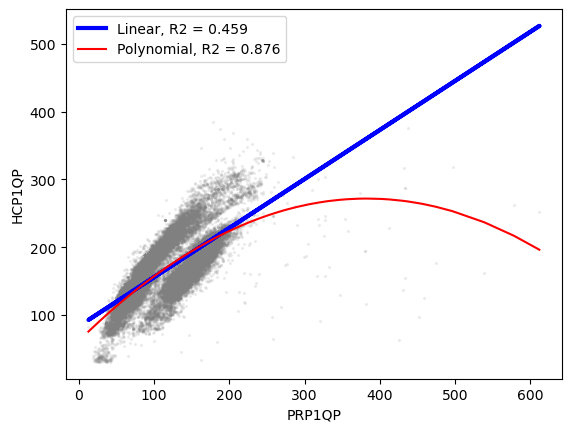

In [51]:
'''
Here it is illustrated how you can perform a linear or polynomial regression
on evaluated datasets. You can create suited models to predict a target 
variable. In the example below, the scikit-learn (sklearn) is used to perform
a linear regression, while numpy (np) is used to do a polynomial regression.

In this example, a regression is made between two of the EMI datasets, which has
no practical sense. In reality, you can use these functions to investigate the 
relationship between sensor data and target properties at sample locations, to
drive stochastic modelling procedures.
'''
# specify which dataframe you want to use (calibration_set, validation_set, df).
#       you can also combine the calibration and validation sets like this:
#       >> dataframe = pd.concat([calibration_set, validation_set])

dataframe = df

# specify the columns of the dataframe you want to use.
column_1 = 'PRP1QP'
column_2 = 'HCP1QP'

# assign these to two variables, dataset 1 and 2
dataset_1 = dataframe[column_1].values
dataset_2 = dataframe[column_2].values

'''
to directly use a column of a pandas dataframe in sklearn, we have to make 
explicit the dimensions of the array. You can do this by converting the 
dataframe or dataframe column to a numpy array, or simply by reshaping the 
column you're working with to the correct form as done below.
'''

len_1 = len(dataset_1)
array_1 = dataset_1.reshape(len_1,1)
array_2 = dataset_2.reshape(len_1,1)

# Perform a linear regression with Scikit-learn (sklearn)
lin_reg = linear_model.LinearRegression()
lin_reg.fit(array_1,array_2) # perform a fit on both datasets
lin_pred = lin_reg.predict(array_1)

# Perform a polynomial regression with Numpy (np)
poly_degree = 2
poly_fit = np.poly1d(np.polyfit(dataset_1, dataset_2, poly_degree))
poly_range = np.linspace(
                         np.floor(dataset_1.min()),
                         np.ceil(dataset_1.max()),
                         100
                         )
poly_pred = poly_fit(np.sort(dataset_1)) # get the polynomial regression 
                                         # across the desired range

# Get the coefficient of determination of the performed regressions
#   for this we simply use the sklearn function r2_score

lin_score = r2_score(dataset_2,lin_pred)
ply_score = r2_score(np.sort(dataset_2),poly_pred)

# Plot the results
#   the rounded r-squared values are given in the legend (convert float to 
#   string using >str(); rounding to 3 digits using >np.round()).

plt.scatter(dataset_1, dataset_2,  alpha = 0.1, s = 2, color='gray')
plt.plot(dataset_1,
            lin_pred, 
            color='blue', 
            linewidth=3, 
            label = 'Linear, R2 = ' + str(np.round(lin_score,3))
            )
plt.plot(np.sort(dataset_1), 
            poly_pred, 
            color = 'red', 
            label = 'Polynomial, R2 = ' + str(np.round(ply_score,3))
            )
plt.xlabel(column_1)
plt.ylabel(column_2)
plt.legend()
plt.show()